<a href="https://colab.research.google.com/github/andrew5403/crhouseprice/blob/main/HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre Processing

In [ ]:
# Data Pre-Processing
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler

# Mount Google Drive to load data
drive.mount('/content/drive')

# Load the training dataset
train_data = pd.read_csv('/content/drive/MyDrive/houseprice/train.csv')

# Display the first few rows of the dataset
print(train_data.head())

# Get a summary of the dataset
print(train_data.info())

# Check for missing values
missing_values = train_data.isnull().sum()
print("Columns with missing values:\n", missing_values[missing_values > 0])

# Handle Missing Values
# Categorical columns where 'NA' represents "Not Applicable"
categorical_na_columns = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

# Replace NaN with 'None' for categorical features where 'NA' means "Not Applicable"
for col in categorical_na_columns:
    train_data[col].fillna('None', inplace=True)

# Numerical columns with missing values
numerical_na_columns = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

# Replace NaN with the median value for numerical features
for col in numerical_na_columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)

# Handle remaining missing values
# Replace NaN in 'MasVnrType' with 'None' to indicate no masonry veneer
train_data['MasVnrType'].fillna('None', inplace=True)

# Replace NaN in 'Electrical' with the mode of the column (most common value)
train_data['Electrical'].fillna(train_data['Electrical'].mode()[0], inplace=True)

# Feature Engineering: Adding new features
train_data['TotalArea'] = train_data['GrLivArea'] + train_data['TotalBsmtSF'] + train_data['LotArea']
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
train_data['TotalBath'] = train_data['FullBath'] + (0.5 * train_data['HalfBath']) + train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath'])
train_data['TotalPorchArea'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + train_data['3SsnPorch'] + train_data['ScreenPorch']

# Drop unnecessary features
train_data.drop(['Id'], axis=1, inplace=True) # Drop 'Id' as it's not useful for prediction

# Display dataset info after handling remaining missing values
print("\nDataset info after handling missing values and adding new features:")
print(train_data.info())

# Encode Categorical Features
# One-hot encode categorical features
train_data = pd.get_dummies(train_data)

# Feature Scaling
# List of numerical features to scale
numerical_features = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
    'TotalArea', 'HouseAge', 'RemodAge', 'TotalBath', 'TotalPorchArea'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Display dataset info after scaling
print("\nDataset info after scaling numerical features:")
print(train_data.info())


Mounted at /content/drive
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePri

# Test Train Split

In [ ]:
from sklearn.model_selection import train_test_split

# Separate the features (X) and target (y)
X = train_data.drop(columns=['SalePrice'])
y = train_data['SalePrice']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)



Training set shape: (1168, 307)
Validation set shape: (292, 307)


# Model Training and Evaluation (Random Forest)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use Cross-Validation to evaluate the model (5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

# Train Random Forest on the Training Set
rf_model.fit(X_train, y_train)

# Predict on the Validation Set
y_pred_rf = rf_model.predict(X_valid)

# Evaluate the Random Forest Model
mse_rf = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

# Print Cross-Validation Scores and Evaluation Metrics
print("\nCross-Validation R² Scores:", cv_scores)
print("Average Cross-Validation R² Score:", np.mean(cv_scores))
print("\nRandom Forest Model Performance Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"R² Score: {r2_rf}")



Cross-Validation R² Scores: [0.87752339 0.84855749 0.87019909 0.87913944 0.81166237]
Average Cross-Validation R² Score: 0.8574163549471253

Random Forest Model Performance Metrics:
Mean Squared Error: 830906071.8143747
Root Mean Squared Error: 28825.441398430914
R² Score: 0.8916726551947931


# Model Training and Evaluation (Decision Tree)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Use Cross-Validation to evaluate the model (5-fold cross-validation)
cv_scores_dt = cross_val_score(dt_model, X, y, cv=5, scoring='r2')

# Train Decision Tree on the Training Set
dt_model.fit(X_train, y_train)

# Predict on the Validation Set
y_pred_dt = dt_model.predict(X_valid)

# Evaluate the Decision Tree Model
mse_dt = mean_squared_error(y_valid, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_valid, y_pred_dt)

# Print Cross-Validation Scores and Evaluation Metrics
print("\nDecision Tree Cross-Validation R² Scores:", cv_scores_dt)
print("Average Decision Tree Cross-Validation R² Score:", np.mean(cv_scores_dt))
print("\nDecision Tree Model Performance Metrics:")
print(f"Mean Squared Error: {mse_dt}")
print(f"Root Mean Squared Error: {rmse_dt}")
print(f"R² Score: {r2_dt}")



Decision Tree Cross-Validation R² Scores: [0.7026311  0.67339192 0.79657738 0.73326944 0.66664552]
Average Decision Tree Cross-Validation R² Score: 0.7145030711366719

Decision Tree Model Performance Metrics:
Mean Squared Error: 1620833564.6130137
Root Mean Squared Error: 40259.577302960024
R² Score: 0.788687792300895


# Tuning

In [ ]:
# Section 4: Hyperparameter Tuning

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid to search
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV: Randomized hyperparameter search
# Reduced number of iterations and 3-fold CV for speed optimization
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,  # Number of folds in cross-validation
    scoring='r2',  # Use R² as scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Verbose output for tracking progress
    random_state=42
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Train and Evaluate Optimized Model
# Retrieve the best model from random search
best_rf_model = random_search.best_estimator_

# Predict on validation set using the optimized model
y_pred_best_rf = best_rf_model.predict(X_valid)

# Calculate and print evaluation metrics
mse_best_rf = mean_squared_error(y_valid, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_valid, y_pred_best_rf)

print("\nOptimized Random Forest Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse_best_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_rf}")
print(f"R² Score: {r2_best_rf}")

# Optional: Compare metrics with the previous baseline model to show improvements
print("\nComparison with Baseline Random Forest Model:")
print(f"Baseline R² Score: {r2_rf}")
print(f"Optimized R² Score: {r2_best_rf}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Optimized Random Forest Model Performance Metrics:
Mean Squared Error (MSE): 1105013530.95933
Root Mean Squared Error (RMSE): 33241.74380142128
R² Score: 0.8559365663061465

Comparison with Baseline Random Forest Model:
Baseline R² Score: 0.8916726551947931
Optimized R² Score: 0.8559365663061465


# Model Evaluation


Comparison of Evaluation Metrics for Random Forest and Decision Tree:
           Model  Cross-Validation R² Score  Mean Squared Error (MSE)  \
0  Random Forest                   0.857416              8.309061e+08   
1  Decision Tree                   0.714503              1.620834e+09   

   Root Mean Squared Error (RMSE)  R² Score  
0                    28825.441398  0.891673  
1                    40259.577303  0.788688  


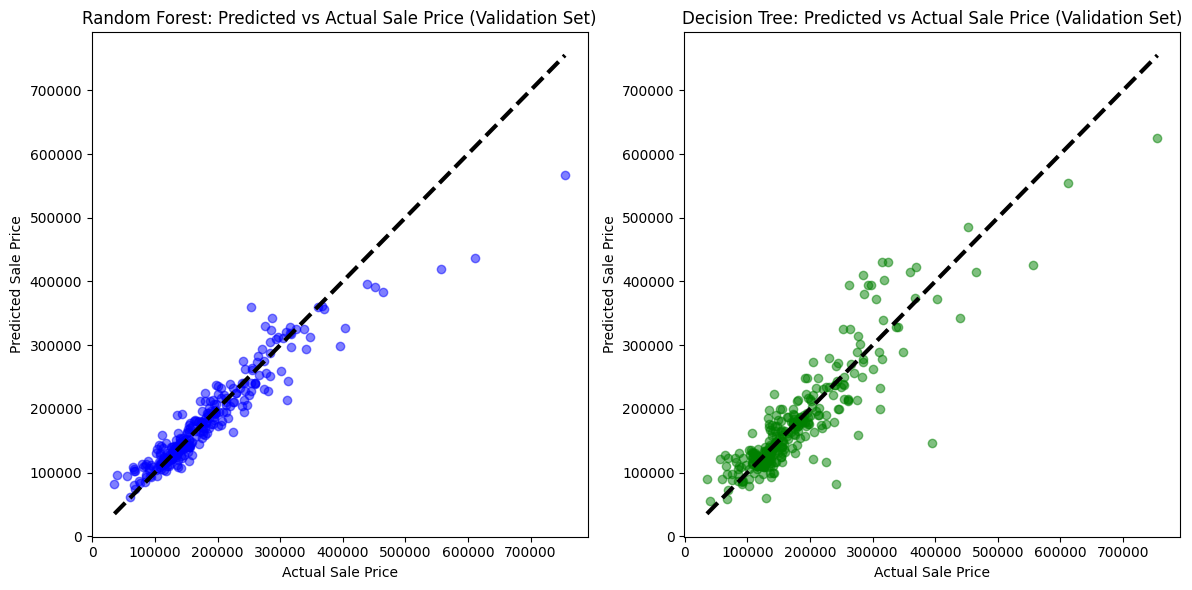

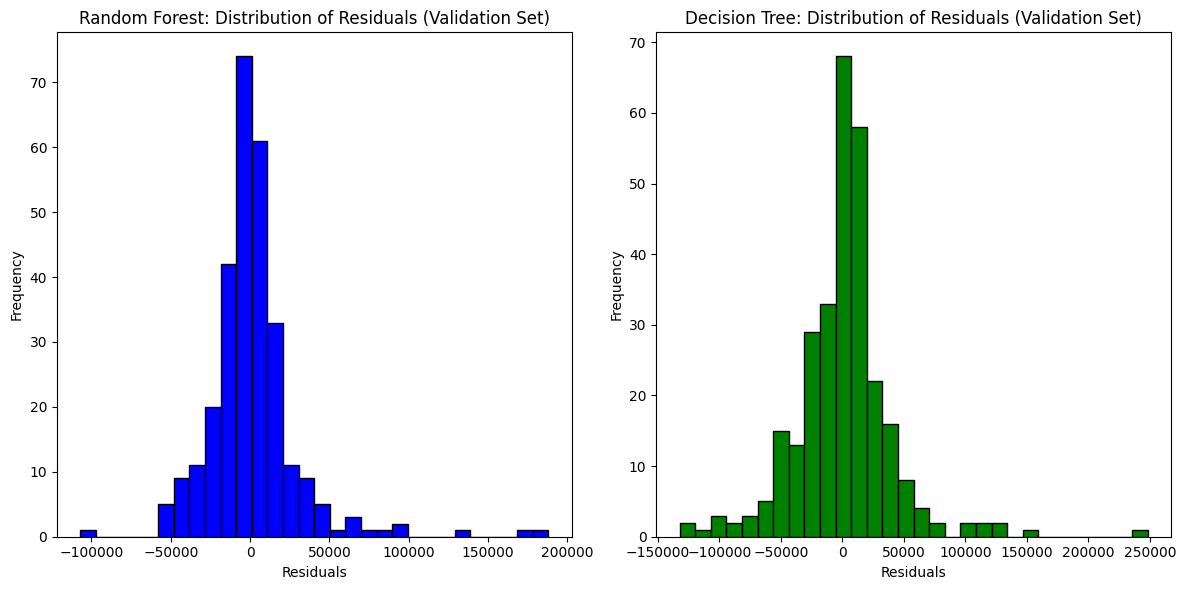

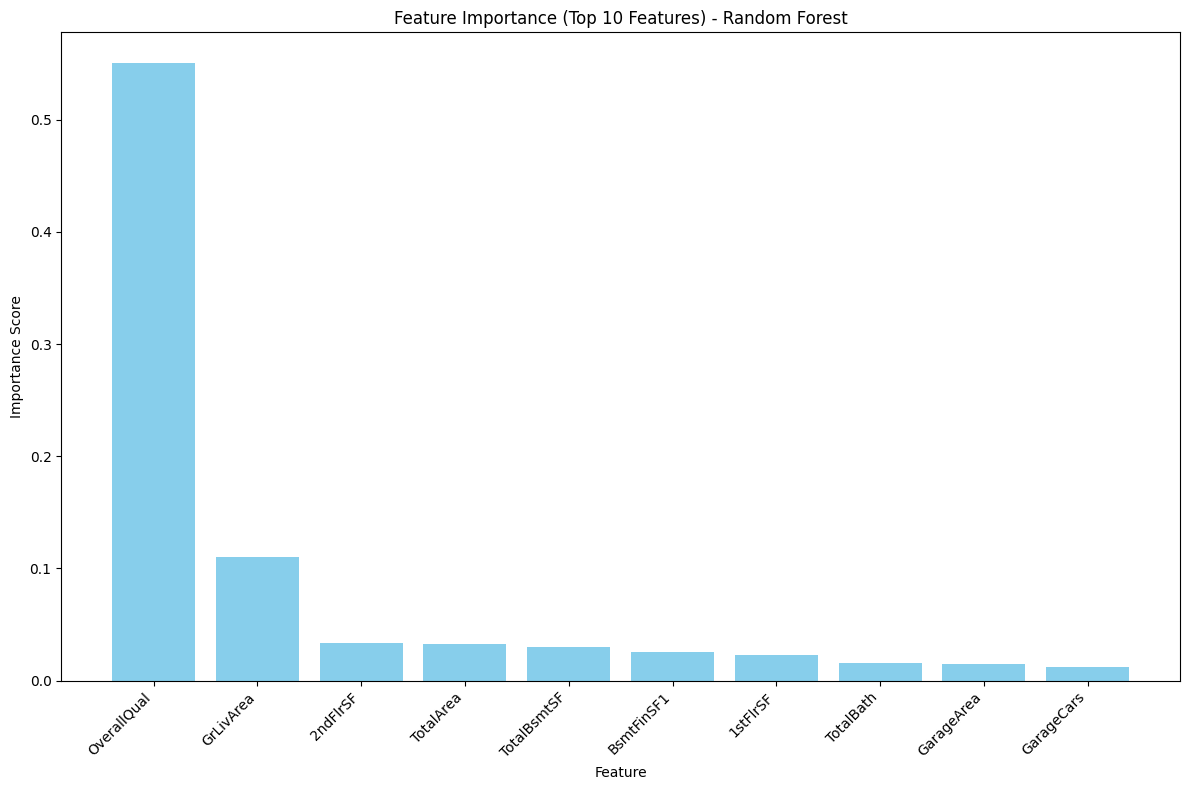


Top 10 Important Features for Random Forest Model:
       Feature  Importance
0  OverallQual    0.550293
1    GrLivArea    0.110289
2     2ndFlrSF    0.033262
3    TotalArea    0.032357
4  TotalBsmtSF    0.029668
5   BsmtFinSF1    0.025409
6     1stFlrSF    0.023067
7    TotalBath    0.016117
8   GarageArea    0.014569
9   GarageCars    0.011946


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Collect metrics for both models

# Random Forest metrics
cv_scores_rf = cv_scores  # Already defined when evaluating Random Forest earlier
mse_rf = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

# Decision Tree metrics
cv_scores_dt = cross_val_score(dt_model, X, y, cv=5, scoring='r2')
y_pred_dt = dt_model.predict(X_valid)
mse_dt = mean_squared_error(y_valid, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_valid, y_pred_dt)

# Creating a summary table
data = {
    'Model': ['Random Forest', 'Decision Tree'],
    'Cross-Validation R² Score': [np.mean(cv_scores_rf), np.mean(cv_scores_dt)],
    'Mean Squared Error (MSE)': [mse_rf, mse_dt],
    'Root Mean Squared Error (RMSE)': [rmse_rf, rmse_dt],
    'R² Score': [r2_rf, r2_dt]
}

metrics_df = pd.DataFrame(data)

# Display the comparison table
print("\nComparison of Evaluation Metrics for Random Forest and Decision Tree:")
print(metrics_df)

# Plotting Predicted vs Actual Sale Prices for Random Forest and Decision Tree
plt.figure(figsize=(12, 6))

# Random Forest: Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_valid, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=3)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Random Forest: Predicted vs Actual Sale Price (Validation Set)')

# Decision Tree: Predicted vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_valid, y_pred_dt, alpha=0.5, color='green')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=3)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Decision Tree: Predicted vs Actual Sale Price (Validation Set)')

plt.tight_layout()
plt.show()

# Plotting Residuals for Random Forest and Decision Tree
plt.figure(figsize=(12, 6))

# Random Forest Residuals
plt.subplot(1, 2, 1)
residuals_rf = y_valid - y_pred_rf
plt.hist(residuals_rf, bins=30, edgecolor='black', color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest: Distribution of Residuals (Validation Set)')

# Decision Tree Residuals
plt.subplot(1, 2, 2)
residuals_dt = y_valid - y_pred_dt
plt.hist(residuals_dt, bins=30, edgecolor='black', color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Decision Tree: Distribution of Residuals (Validation Set)')

plt.tight_layout()
plt.show()

# Feature Importance (Random Forest Specific)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.title("Feature Importance (Top 10 Features) - Random Forest")
plt.bar(range(10), importances[indices[:10]], align="center", color='skyblue')
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Display Feature Importance Table
important_features = pd.DataFrame({'Feature': features[indices], 'Importance': importances[indices]})
print("\nTop 10 Important Features for Random Forest Model:")
print(important_features.head(10))


# Test Dataset

In [ ]:
# Section 1: Data Pre-Processing
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler

# Mount Google Drive to load data
drive.mount('/content/drive', force_remount=True)

# Load the training dataset
train_data = pd.read_csv('/content/drive/MyDrive/houseprice/train.csv')

# Handle Missing Values
# Categorical columns where 'NA' represents "Not Applicable"
categorical_na_columns = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

# Replace NaN with 'None' for categorical features where 'NA' means "Not Applicable"
for col in categorical_na_columns:
    train_data[col].fillna('None', inplace=True)

# Numerical columns with missing values
numerical_na_columns = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

# Replace NaN with the median value for numerical features
for col in numerical_na_columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)

# Handle remaining missing values
train_data['MasVnrType'].fillna('None', inplace=True)
train_data['Electrical'].fillna(train_data['Electrical'].mode()[0], inplace=True)

# Feature Engineering: Adding new features
train_data['TotalArea'] = train_data['GrLivArea'] + train_data['TotalBsmtSF'] + train_data['LotArea']
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
train_data['TotalBath'] = train_data['FullBath'] + (0.5 * train_data['HalfBath']) + train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath'])
train_data['TotalPorchArea'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + train_data['3SsnPorch'] + train_data['ScreenPorch']

# Drop unnecessary features
train_data.drop(['Id'], axis=1, inplace=True)

# One-hot encode categorical features
train_data = pd.get_dummies(train_data)

# Feature Scaling
numerical_features = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
    'TotalArea', 'HouseAge', 'RemodAge', 'TotalBath', 'TotalPorchArea'
]

scaler = StandardScaler()

# Fit and transform the numerical features in the training data
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Section 2: Apply Same Pre-Processing to Test Data
# Load the test dataset
test_data = pd.read_csv('/content/drive/MyDrive/houseprice/test.csv')

# Handle Missing Values in the test dataset (same as training data)
for col in categorical_na_columns:
    test_data[col].fillna('None', inplace=True)

for col in numerical_na_columns:
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Handle remaining missing values in the test dataset
test_data['MasVnrType'].fillna('None', inplace=True)
test_data['Electrical'].fillna(test_data['Electrical'].mode()[0], inplace=True)

# Feature Engineering for the test data (same as training data)
test_data['TotalArea'] = test_data['GrLivArea'] + test_data['TotalBsmtSF'] + test_data['LotArea']
test_data['HouseAge'] = test_data['YrSold'] - test_data['YearBuilt']
test_data['RemodAge'] = test_data['YrSold'] - test_data['YearRemodAdd']
test_data['TotalBath'] = test_data['FullBath'] + (0.5 * test_data['HalfBath']) + test_data['BsmtFullBath'] + (0.5 * test_data['BsmtHalfBath'])
test_data['TotalPorchArea'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] + test_data['ScreenPorch']

# Keep the original Id column for the final submission file
test_ids = test_data['Id']

# Drop unnecessary features in the test dataset
test_data.drop(['Id'], axis=1, inplace=True)

# One-hot encode categorical features in the test dataset
test_data = pd.get_dummies(test_data)

# Align columns of test data with training data
missing_cols = set(train_data.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0

# Ensure the order of columns in the test data matches the training data
test_data = test_data[train_data.columns.drop('SalePrice')]

# Scale numerical features in the test data using the scaler fitted on the training data
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

# Section 3: Model Training
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Separate features and target from training data
X = train_data.drop(columns=['SalePrice'])
y = train_data['SalePrice']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Section 4: Make Predictions on Test Data and Save to Google Drive
# Predict SalePrice for the test data
test_predictions = rf_model.predict(test_data)

# Create a DataFrame for the results matching the Kaggle submission format
results = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions})

# Save the results to a CSV file in your Google Drive folder named "houseprice"
output_path = '/content/drive/MyDrive/houseprice/predicted_house_prices.csv'
results.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")


Mounted at /content/drive
Predictions saved to: /content/drive/MyDrive/houseprice/predicted_house_prices.csv
